In [209]:
#Common imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import cvxpy as cp
from numpy import linalg
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import mosek

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
cp.installed_solvers()

['CVXOPT', 'ECOS', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCS']

In [101]:
df = pd.read_csv("diabetes.csv")

In [107]:
X = df.drop("Outcome", axis = 1)
Y = df["Outcome"].to_numpy()
Y = np.where(Y == 0, -1, 1)

mm_scaler = MinMaxScaler()
X_scaled = mm_scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=100)


In [184]:
X_class, y_class = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)

y_class = np.where(y_class == 0, -1, 1)

X_circles, y_circles = make_circles(n_samples=100, noise=0.2, factor=0.5, random_state=1)

y_circles = np.where(y_circles == 0, -1, 1)


X_moons, y_moons = make_moons(n_samples=100, noise=0.3, random_state=0)

y_moons = np.where(y_moons == 0, -1, 1)


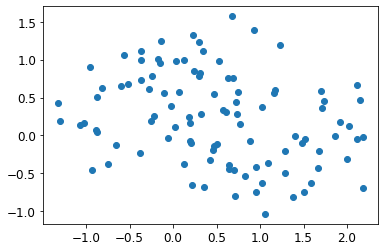

In [6]:
plt.scatter(X_moons[0:,0], X_moons[0:,1])

In [234]:
class Perceptron:
    
    def __init__ (self, niter = 10, LR = 10):
        
        self.niter = niter 
        self.LR = LR 
        
        
    def get_params(self, deep=True):
        return {"niter" : self.niter, "LR" : self.LR}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
        
        
    def fit (self, x, y ):
        self.m = []
        accuracy = np.ones(self.niter)
        max_accuracy = 0
        
        self.weight = np.ones(1 + x.shape[1])
        
        for i in range(self.niter):
            #m_count = 0
            for x_row , y_row in zip(x,y):
                loss = self.LR * (y_row - self.activation_out(x_row))
                self.weight[1:] += self.LR * x_row.dot(loss)
                self.weight[0] += self.LR * loss
                #m_count += int((y_row *(self.activation_out(x_row))) >= 1.0)
                #m_count += int(loss != 0.0)
            m_count = ((y - self.activation_out(x))**2).sum() / 2.0
            self.m.append(m_count)
            
            accuracy[i] = accuracy_score(self.predict(x), y)
            if (accuracy[i] > max_accuracy):
                max_accuracy = accuracy[i]
                chkptw = self.weight[1:]
                chkptb = self.weight[0]
                
        self.weight[1:] = chkptw
        self.weight[0] = chkptb
                
            
        return self
                
                
                
                
    def activation_out(self, x):
        
        #percep = np.dot(self.weight[1:], x) + self.weight[0]
#         np.where(np.dot(self.weight[1:], x) + self.weight[0] >= 0.0 , 1, -1)
        
        return np.dot(x , self.weight[1:] ) + self.weight[0]
    
    def predict(self, x): 
        
        y = []
        
        for x1 in x:
            
            results = np.where(self.activation_out(x1) >= 0.0 , 1, -1)
            y.append(results)
            
        return np.array(y)
    
    def show_weights (self):
        
        print ("W = ", self.weight[1:])
        print("\n")
        
        print("bias = ", self.weight[0])

In [154]:
class SVM_PRIMAL:
    
    
    def __init__ (self, regularisation_para_C =1 ):
        
        self.regularisation_para_C = regularisation_para_C 
        
        
        
    def get_params(self, deep=True):
        return {"regularisation_para_C" : self.regularisation_para_C}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    
    def fit (self, data_train, label_train):
        
        n_samples = len(data_train)
        n = data_train.shape[0]
        d = data_train.shape[1]

        W = cp.Variable((d))
        bias = cp.Variable()
        epi = cp.Variable(n)
        C = cp.Parameter()
        C.value = self.regularisation_para_C

        obj = cp.Minimize((1/2 * cp.norm(W) + 1/n_samples*C*cp.sum(epi) ))

        constranit_1 = [cp.multiply(label_train,(data_train@W+bias)) >= (1-epi)]

        constraint_2 = [epi >= 0]

        constraints = constranit_1 + constraint_2

        prob = cp.Problem(obj, constraints)

        prob.solve(solver=cp.MOSEK)

        #print (prob.status)

        self.w = W.value
        self.b = bias.value
        
        
                                       
        return self
                                       
    def predict(self, X):
                                       
        predicted = []
    
        for xi in X:
            results = np.where((np.dot(xi, self.w) + self.b) >= 0.0 , 1, -1)
            predicted.append(results)
                
                    
        return np.array(predicted)
                                       
                                       
                                       
    def show_weights (self):

        print ("W = ", self.w)
        print("\n")
        print("bias = ", self.b)
    
            
        
    
    

In [208]:
class SVM_Dual:


    def __init__ (self, regularisation_para_C =1, kernel = "linear", polyshift=1, degree=3, sigma = 1, gamma =1 ):
        
        self.regularisation_para_C = regularisation_para_C 
        self.kernel = kernel
        self.degree = degree
        self.polyshift = polyshift
        self.sigma = sigma
        self.gamma = gamma
        self.kernel_choice = {"linear":self.linear_kernel,
                                "gaussian":self.gaussian_kernel,
                                "poly":self.polynomial_kernel,
                                "rbf": self.rbf_kernel
                             }
        

    
    
    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self, x, y):
        return (self.polyshift + np.dot(x, y)) ** self.degree

    def gaussian_kernel(self, x, y):
        return np.exp(-linalg.norm(x-y)**2 / (2 * (self.sigma ** 2)))
    
    def rbf_kernel(self, x, y):    
        distance = np.linalg.norm(x - y) ** 2
        return np.exp(-self.gamma * distance)
    
    def get_params(self, deep=True):
        return {"kernel": self.kernel, "degree": self.degree,
                "polyshift":self.polyshift, "sigma": self.sigma,
               "regularisation_para_C" : self.regularisation_para_C,
               "gamma":self.gamma}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    
    def fit (self, data_train, label_train):
        n_samples = len(data_train)
        n = data_train.shape[0]
        d = data_train.shape[1]

        alpha = cp.Variable((n))
        C = cp.Parameter()
        C.value = self.regularisation_para_C
        
        K = np.zeros((n_samples, n_samples))
        
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel_choice[self.kernel](data_train[i], data_train[j])
        
        
        H = np.outer(label_train[:,None],label_train[:,None]) * K      
       
       # H = np.dot((label_train[:,None] * data_train) , (  label_train[:,None] * data_train).T)

        obj = cp.Minimize(- cp.sum(alpha)+(1/2)*cp.quad_form(alpha,H))

        constraint_1 = [alpha >= 0]
        constaint_2 = [alpha <= C]
        constraint_3 = [(label_train@alpha) == 0]

        constraint = constraint_1 + constaint_2 + constraint_3

        prob = cp.Problem(obj, constraint)

        results = prob.solve(solver=cp.MOSEK)
        #print (prob.status)
        #print(alpha.value)


#         aaa = alpha.value
#         aaa = np.where(aaa>1e-5 , aaa, 0)
#         w_dual = ((label_train.T * aaa.T) @ data_train)  
#         aaa = np.where(aaa>self.regularisation_para_C-0.1 , 0, aaa)
#         S = (aaa > 0).flatten()
#         b = label_train[S] - np.dot(data_train[S], w_dual[0])

#         self.weight_w_bias = np.concatenate(([b[0]],w_dual[0]))
        aa = alpha.value
        aa1 = aa.reshape(n_samples)
        sv = aa1 > 1e-8
        self.ind = (np.arange(len(aa1))[sv])
        self.aa1 = aa1[sv]
        self.sv_x = data_train[sv]
        self.sv_y = label_train[sv]

#         print(len(self.sv_y))
#         print(self.sv_y)
        
        
        self.bias = 0
        for n in range(self.aa1.shape[0]):
            self.bias += self.sv_y[n]
            self.bias -= np.sum(self.aa1*self.sv_y * K[self.ind[n],sv])

        self.bias /= self.aa1.shape[0]
        
        
        
        if self.kernel== "linear" :
            self.w = np.zeros(d)
            for n in range(len(self.aa1)):
                self.w += (self.aa1[n] * self.sv_y[n] * self.sv_x[n])
                
        return self

            
            
    def predict(self, X):
        predicted = []
        
        if self.kernel == "linear":
            
            for xi in X:
                results = np.where((np.dot(xi, self.w) + self.bias) >= 0.0 , 1, -1)
                predicted.append(results)
                
        elif self.kernel != "linear":
            
            for i in range(len(X)):
                y_predict = 0 
                for b, a , c in zip(self.sv_x, self.aa1, self.sv_y):
                    y_predict += a * c * self.kernel_choice[self.kernel](b,X[i])
                y_predict = y_predict+ self.bias
                predicted.append(np.sign(y_predict))
                    
        return np.array(predicted)

        
    
    def show_weights (self):
        
        if self.kernel == "linear":
            print ("W = ", self.w)
            print("\n")
            print("bias = ", self.bias)
            print("\n")
            print ("Number of support vectors ", len(self.ind))
            
            
        elif self.kernel != "linear":
            print ("Number of support vectors ", len(self.ind))
            
            
        


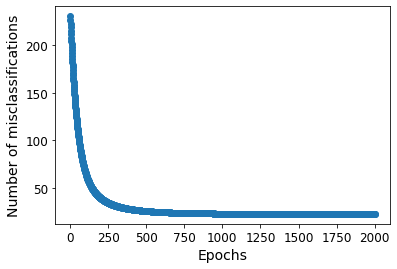

Accuracy score:  0.84
Metrics Report
              precision    recall  f1-score   support

          -1       0.83      0.86      0.84        50
           1       0.85      0.82      0.84        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



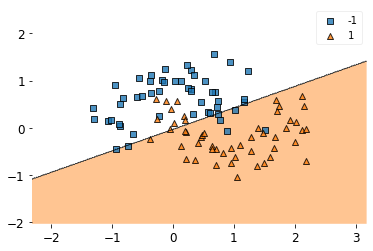

In [160]:
clf_percentron_moons = Perceptron(2000, 0.009)
clf_percentron_moons.fit(X_moons, y_moons)

predicted_percentron_moons = clf_percentron_moons.predict(X_moons)

plt.plot(range(1, len(clf_percentron_moons.m) + 1), clf_percentron_moons.m, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.show()

plot_decision_regions(X_moons, y_moons, clf=clf_percentron_moons)

print('Accuracy score: ', accuracy_score(y_moons, predicted_percentron_moons))
print('Metrics Report')
print(classification_report(y_moons, predicted_percentron_moons))

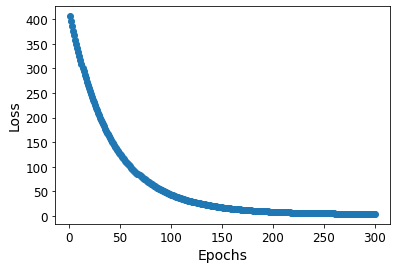

Accuracy score:  1.0
Metrics Report
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



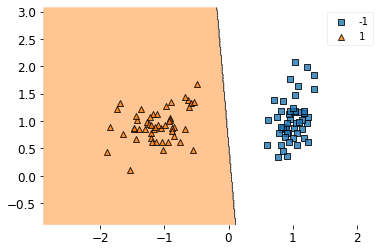

In [191]:
clf_percentron_class = Perceptron(300, 0.009)
clf_percentron_class.fit(X_class, y_class)
predicted_percentron_class = clf_percentron_class.predict(X_class)

plt.plot(range(1, len(clf_percentron_class.m) + 1), clf_percentron_class.m, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plot_decision_regions(X_class, y_class, clf=clf_percentron_class)

print('Accuracy score: ', accuracy_score(y_class, predicted_percentron_class))
print('Metrics Report')
print(classification_report(y_class, predicted_percentron_class))

Accuracy score:  1.0
Metrics Report
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



<AxesSubplot:>

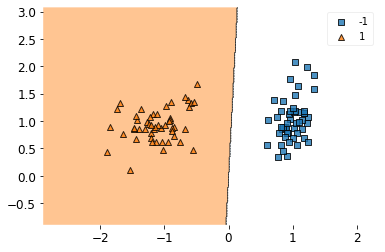

In [187]:
# clf_svm_rbf = SVM(130, "rbf")
# clf_svm_poly = SVM(kernel="poly")
clf_svm_linear = SVM_PRIMAL(1000)




clf_svm_linear.fit(X_class, y_class)
predicted_svm = clf_svm_linear.predict(X_class)

# plt.plot(range(1, len(clf_percentron.m) + 1), clf_percentron.m, marker='o')
# plt.xlabel('Epochs')
# plt.ylabel('Number of misclassifications')
# plt.show()

print('Accuracy score: ', accuracy_score(y_class, predicted_svm))
print('Metrics Report')
print(classification_report(y_class, predicted_svm))

plot_decision_regions(X_class, y_class, clf=clf_svm_linear)


Accuracy score:  0.8
Metrics Report
              precision    recall  f1-score   support

          -1       0.79      0.82      0.80        50
           1       0.81      0.78      0.80        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



<AxesSubplot:>

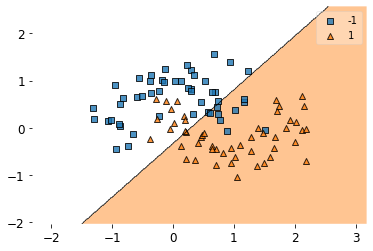

In [206]:
clf_svm_non_linear = SVM_PRIMAL(0.9)




clf_svm_non_linear.fit(X_moons, y_moons)
predicted_non_svm = clf_svm_non_linear.predict(X_moons)

# plt.plot(range(1, len(clf_percentron.m) + 1), clf_percentron.m, marker='o')
# plt.xlabel('Epochs')
# plt.ylabel('Number of misclassifications')
# plt.show()

print('Accuracy score: ', accuracy_score(y_moons, predicted_non_svm))
print('Metrics Report')
print(classification_report(y_moons, predicted_non_svm))

plot_decision_regions(X_moons, y_moons, clf=clf_svm_non_linear)

In [156]:
clf_svm_linear.show_weights()

W =  [-1.75451613  0.0777831 ]


bias =  0.0038148619732457476


In [157]:
from sklearn.svm import SVC

clf = SVC(C = 1000, kernel = 'linear')
clf.fit(X_class, y_class) 
predicted_svm_sk = clf.predict(X_class)
print('w = ',clf.coef_)
print('b = ',clf.intercept_)

w =  [[-1.75535085  0.07782019]]
b =  [0.00365806]


In [207]:

C_range = np.logspace(5, 10, 30)
gamma_range = np.logspace(-5, 1, 30)

params = dict(sigma=gamma_range, regularisation_para_C=C_range)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

svm_rbf = GridSearchCV(SVM_Dual(kernel="rbf"), param_grid=params, cv=4 , scoring='f1', verbose = 10, n_jobs= -2 )
svm_rbf.fit(X_moons, y_moons, **{})

Fitting 4 folds for each of 900 candidates, totalling 3600 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  63 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done  91 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-2)]: Done 123 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done 159 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-2)]: Done 199 tasks      | elapsed:  

GridSearchCV(cv=4, estimator=<__main__.SVM_Dual object at 0x7f41e8874890>,
             n_jobs=-2,
             param_grid={'regularisation_para_C': array([1.00000000e+05, 1.48735211e+05, 2.21221629e+05, 3.29034456e+05,
       4.89390092e+05, 7.27895384e+05, 1.08263673e+06, 1.61026203e+06,
       2.39502662e+06, 3.56224789e+06, 5.29831691e+06, 7.88046282e+06,
       1.17210230e+07, 1.74332882e+07, 2.59294380e+07, 3....
       4.52035366e-04, 7.27895384e-04, 1.17210230e-03, 1.88739182e-03,
       3.03919538e-03, 4.89390092e-03, 7.88046282e-03, 1.26896100e-02,
       2.04335972e-02, 3.29034456e-02, 5.29831691e-02, 8.53167852e-02,
       1.37382380e-01, 2.21221629e-01, 3.56224789e-01, 5.73615251e-01,
       9.23670857e-01, 1.48735211e+00, 2.39502662e+00, 3.85662042e+00,
       6.21016942e+00, 1.00000000e+01])},
             scoring='f1', verbose=10)

In [196]:
svm_rbf.best_params_

{'regularisation_para_C': 148735.21072935118, 'sigma': 1e-10}

Accuracy score:  0.87
Metrics Report
              precision    recall  f1-score   support

          -1       1.00      0.74      0.85        50
           1       0.79      1.00      0.88        50

    accuracy                           0.87       100
   macro avg       0.90      0.87      0.87       100
weighted avg       0.90      0.87      0.87       100



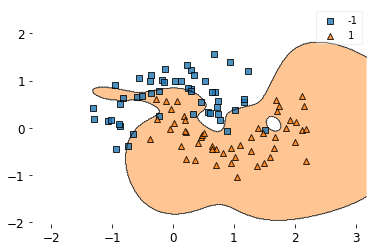

In [197]:
plot_decision_regions(X_moons,y_moons, clf=svm_rbf.best_estimator_)

predicted_SVM_rbf_class = svm_rbf.predict(X_moons)
print('Accuracy score: ', accuracy_score(y_moons, predicted_SVM_rbf_class))
print('Metrics Report')
print(classification_report(y_moons, predicted_SVM_rbf_class))

In [15]:
#C_range = np.logspace(1, 3 , 30)
C_range = np.linspace(10, 600, 30)
degree = [3,2]
polyshift = np.linspace(1, 10, 10)


params = dict(degree=degree, regularisation_para_C=C_range, polyshift = polyshift)

svm_poly = GridSearchCV(SVM_Dual(kernel="poly"), param_grid=params, cv=4 , scoring='f1', verbose = 10, n_jobs= -2 )
svm_poly.fit(X_moons, y_moons, **{})

Fitting 4 folds for each of 600 candidates, totalling 2400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0753s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  78 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 130 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 160 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 190 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done 224 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done 258 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done 296 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done 334 ta

GridSearchCV(cv=4, estimator=<__main__.SVM object at 0x7f422f612850>, n_jobs=-2,
             param_grid={'degree': [3, 2],
                         'polyshift': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'regularisation_para_C': array([ 10.        ,  30.34482759,  50.68965517,  71.03448276,
        91.37931034, 111.72413793, 132.06896552, 152.4137931 ,
       172.75862069, 193.10344828, 213.44827586, 233.79310345,
       254.13793103, 274.48275862, 294.82758621, 315.17241379,
       335.51724138, 355.86206897, 376.20689655, 396.55172414,
       416.89655172, 437.24137931, 457.5862069 , 477.93103448,
       498.27586207, 518.62068966, 538.96551724, 559.31034483,
       579.65517241, 600.        ])},
             scoring='f1', verbose=10)

In [16]:
svm_poly.best_params_

{'degree': 3, 'polyshift': 1.0, 'regularisation_para_C': 600.0}

<AxesSubplot:>

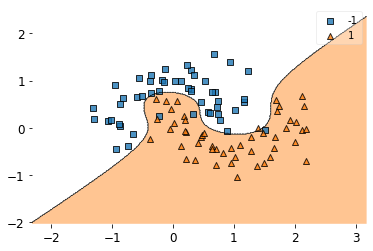

In [17]:
plot_decision_regions(X_moons,y_moons, clf=svm_poly.best_estimator_)

In [18]:
predicted_SVM_poly_class = svm_poly.predict(X_moons)
print('Accuracy score: ', accuracy_score(y_moons, predicted_SVM_poly_class))
print('Metrics Report')
print(classification_report(y_moons, predicted_SVM_poly_class))

Accuracy score:  0.96
Metrics Report
              precision    recall  f1-score   support

          -1       0.98      0.94      0.96        50
           1       0.94      0.98      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [309]:
C_range = np.logspace(-5,10 , 20)


params = dict(regularisation_para_C=C_range)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

svm_linear_final = GridSearchCV(SVM_PRIMAL(), param_grid=params, cv=cv , scoring='f1', verbose = 10, n_jobs= -2 )
svm_linear_final.fit(x_train, y_train, **{})

Fitting 15 folds for each of 20 candidates, totalling 300 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0717s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  78 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 130 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 160 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 190 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 224 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done 258 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    2.5s finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=<__main__.SVM_PRIMAL object at 0x7f41e8a71410>,
             n_jobs=-2,
             param_grid={'regularisation_para_C': array([1.00000000e-05, 6.15848211e-05, 3.79269019e-04, 2.33572147e-03,
       1.43844989e-02, 8.85866790e-02, 5.45559478e-01, 3.35981829e+00,
       2.06913808e+01, 1.27427499e+02, 7.84759970e+02, 4.83293024e+03,
       2.97635144e+04, 1.83298071e+05, 1.12883789e+06, 6.95192796e+06,
       4.28133240e+07, 2.63665090e+08, 1.62377674e+09, 1.00000000e+10])},
             scoring='f1', verbose=10)

In [310]:
svm_linear_final.best_params_

{'regularisation_para_C': 4832.930238571752}

In [311]:
svm_linear_final_best = svm_linear_final.best_estimator_

In [312]:
predicted_svm_linear_final = svm_linear_final_best.predict(x_test)
print('Accuracy score: ', accuracy_score(y_test, predicted_svm_linear_final))
print('precision_score: ', precision_score(y_test, predicted_svm_linear_final))
print('f1_score: ', f1_score(y_test, predicted_svm_linear_final))
print('Metrics Report')
print(classification_report(y_test, predicted_svm_linear_final))

Accuracy score:  0.7337662337662337
precision_score:  0.6304347826086957
f1_score:  0.5858585858585859
Metrics Report
              precision    recall  f1-score   support

          -1       0.78      0.83      0.80       101
           1       0.63      0.55      0.59        53

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154



In [244]:
C_range = np.logspace(-2, 10, 10)
sigma_range = np.logspace(1, 4, 10)

# C_range = [1,0.1,0.001,0.0001]
# sigma_range = [1,10,100,1000,10000]



params = dict(sigma=sigma_range, regularisation_para_C=C_range)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
svm_rbf_final = GridSearchCV(SVM_Dual(kernel="gaussian"), param_grid=params, cv=cv , scoring='f1', verbose = 10, n_jobs= -2 )
svm_rbf_final.fit(x_train, y_train, **{})

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done  63 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done  76 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done  91 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 123 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-2)]: Done 159 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-2)]: Done 199 tasks      | elapsed:  

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=4, random_state=1),
             estimator=<__main__.SVM_Dual object at 0x7f41e8b3bd10>, n_jobs=-2,
             param_grid={'regularisation_para_C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02,
       2.15443469e+03, 4.64158883e+04, 1.00000000e+06, 2.15443469e+07,
       4.64158883e+08, 1.00000000e+10]),
                         'sigma': array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
         215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
        4641.58883361, 10000.        ])},
             scoring='f1', verbose=10)

In [245]:
svm_rbf_final.best_params_

{'regularisation_para_C': 21544346.90031878, 'sigma': 46.41588833612777}

In [246]:
svm_rbf_final_best = svm_rbf_final.best_estimator_

In [247]:
predicted_SVM_rbf_final = svm_rbf_final_best.predict(x_test)
print('Accuracy score: ', accuracy_score(y_test, predicted_SVM_rbf_final))
print('precision_score: ', precision_score(y_test, predicted_SVM_rbf_final))
print('f1_score: ', f1_score(y_test, predicted_SVM_rbf_final))
print('Metrics Report')
print(classification_report(y_test, predicted_SVM_rbf_final))

Accuracy score:  0.7142857142857143
precision_score:  0.5849056603773585
f1_score:  0.5849056603773585
Metrics Report
              precision    recall  f1-score   support

          -1       0.78      0.78      0.78       101
           1       0.58      0.58      0.58        53

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154



In [248]:
aaa =svm_rbf_final.best_estimator_

aaa.show_weights()

Number of support vectors  614


In [249]:
C_range = np.logspace(-2, 10, 10)
polyshift = [1,2,3,4,5]


params = dict(regularisation_para_C=C_range, polyshift = polyshift)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
svm_poly_final = GridSearchCV(SVM_Dual(kernel="poly", degree=3), param_grid=params, cv=4 , scoring='f1', verbose = 10, n_jobs= -2 )
svm_poly_final.fit(x_train, y_train, **{})

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done  63 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-2)]: Done  76 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-2)]: Done  91 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-2)]: Done 123 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-2)]: Done 159 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  

GridSearchCV(cv=4, estimator=<__main__.SVM_Dual object at 0x7f41e8bc7c50>,
             n_jobs=-2,
             param_grid={'polyshift': [1, 2, 3, 4, 5],
                         'regularisation_para_C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02,
       2.15443469e+03, 4.64158883e+04, 1.00000000e+06, 2.15443469e+07,
       4.64158883e+08, 1.00000000e+10])},
             scoring='f1', verbose=10)

In [250]:
svm_poly_final.best_params_

{'polyshift': 2, 'regularisation_para_C': 0.21544346900318834}

In [251]:
svm_poly_final_best = svm_poly_final.best_estimator_

In [252]:
predicted_SVM_poly_final = svm_poly_final_best.predict(x_test)
print('Accuracy score: ', accuracy_score(y_test, predicted_SVM_poly_final))
print('precision_score: ', precision_score(y_test, predicted_SVM_poly_final))
print('f1_score: ', f1_score(y_test, predicted_SVM_poly_final))
print('Metrics Report')
print(classification_report(y_test, predicted_SVM_poly_final))

Accuracy score:  0.7272727272727273
precision_score:  0.6222222222222222
f1_score:  0.5714285714285715
Metrics Report
              precision    recall  f1-score   support

          -1       0.77      0.83      0.80       101
           1       0.62      0.53      0.57        53

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154



In [253]:
aaa1 =svm_poly_final.best_estimator_

aaa1.show_weights()

Number of support vectors  537


In [254]:
LR1 = np.logspace(-1, -4, 10)



params = dict(LR=LR1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
Perceptron_final = GridSearchCV(Perceptron(niter=2000), param_grid=params, cv=cv 
                                , scoring='f1', verbose = 10, n_jobs= -2 )

Perceptron_final.fit(x_train, y_train, **{})




Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done  63 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done  76 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done  91 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-2)]: Done 123 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-2)]: Done 145 out of 150 | elapsed:  5.3min remaining:   10.9s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:  5.4min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=<__main__.Perceptron object at 0x7f41e89d0550>,
             n_jobs=-2,
             param_grid={'LR': array([0.1       , 0.04641589, 0.02154435, 0.01      , 0.00464159,
       0.00215443, 0.001     , 0.00046416, 0.00021544, 0.0001    ])},
             scoring='f1', verbose=10)

In [255]:
Perceptron_final.best_params_

{'LR': 0.1}

In [256]:
Perceptron_final_best = Perceptron_final.best_estimator_

In [257]:
Perceptron_final_best_predicted = Perceptron_final_best.predict(x_test)
print('Accuracy score: ', accuracy_score(y_test, Perceptron_final_best_predicted))
print('precision_score: ', precision_score(y_test, Perceptron_final_best_predicted))
print('f1_score: ', f1_score(y_test, Perceptron_final_best_predicted))
print('Metrics Report')
print(classification_report(y_test, Perceptron_final_best_predicted))

Accuracy score:  0.7207792207792207
precision_score:  0.6041666666666666
f1_score:  0.5742574257425742
Metrics Report
              precision    recall  f1-score   support

          -1       0.77      0.81      0.79       101
           1       0.60      0.55      0.57        53

    accuracy                           0.72       154
   macro avg       0.69      0.68      0.68       154
weighted avg       0.72      0.72      0.72       154

